### Cohort Analysis - Purpose.
The purpose of a cohort analysis is to extract insights from a group of people characterized by a shared given trait, such as
date, gender, or expenditure.

Cohort analyses are used to extracts insights on a company's customer base and their use of a particular product. 

This is important because it provides insight into how a company can improve its existing product and potentially introduce
new products to market.

The process by which products are introduced to a market is called the product lifecycle. The product lifecycle consists 
of 4 stages - market development, growth, maturity, and decline. In order to improve their existing product offerings and 
expand to new ones, companies will gather data on their customer's use of their product and use this to inform strategic
development of their products.

A cohort analysis can therefore be used to evaluate how a user will interact with a company's product over the course
of their lifetime.

There are 2 primary forms of cohort analysis, both of which can be further divided up into subsequent sub-categories.

The most commonly used are time cohort analyses, where users are grouped together on the basis of date-time characteristics they share, such as date of first product use, which can be denoted as the day the customer was first acquired.



### Cohort Analysis - Requirements.
There are 2 minimum data requirements for a cohort analysis to be performed.
    UID. A unique User ID to track how a user moves throughout the product lifecycle. 
    Transaction Date. A date representing the transactions date of a user.
    
Later on, it is possible to layer on additional analyses such as cost analysis, whereby each cohort is multiplied
by their respective expenditure while using a product. 

These variables should then be transformed as inputs to a pivot table.
The index of the pivot table should represent the datetime that the customers first started using the product - cohort.
The column will then represent the datetime difference since the datetime of the customer's first use of the product - offset.
Finally, the values will represent the number of unique customers found at each datetime offset - nunique.

The index and column variables should be of equal length, and should not exceed that of a length of ~30 as this will prove difficult to visualize in a heatmap.

The final output of a cohort analysis should be a heatmap with the y-axis representing the cohort, the x-axis the offset, and the values the nunique.


### Steps.

Address missing values.

Address datetime formatting and scope.

Evaluate the first unit of the analysis scope to all datetimes for all customers. I.e. For a monthly cohort analysis, assign the first day of each month, year for all customers - and assign back to the same column.

Identify the first transaction date for each customer, and assign to CohortDate.

Calculate the datetime offset between each of the transaction datetimes and the CohortDates, and assign to Offset.

Create a pivot table:
    Index: CohortDate
    Columns: Offset
    Values: nunique(UID)

Calculate retention rate.

Generate heatmap.


### Examples.
Daily cohort analysis.

Monthly cohort analysis.

Yearly cohort analysis.


### Definitions.
Product lifecycle. The process by which products are introduced and adopted by a market.   
Cohort analysis. An analytical framework used to group together users of a product by shared characteristics.   
Analysis scope. The timeframe that will be used to perform the analysis.   
Heatmap. Tool used to visualize cohorts.   
Pivot table. An intermediate data structure that is the input to a heatmap, and is comprised of an index, column, and values variable.
    Index. In a cohort analysis, the variable by which users are grouped according to a shared characteristic.
    Column. In a cohort analysis, the variable used to denote the scope of the analysis.
    Values. In a cohort analysis, the 
Transactions. A variable repesenting the a customer's use of a product. I.e. On a financial platform offering trading services,
transactions would be number of trades.

### Dataset.
Unfortunately there is a lack of publicly available data on product and service usage for tech companies. We wil therefore be generating some sample data based on a hypothetical case study we will be creating for the sake of successfully completing a cohort analysis and calculating the relevant metrics that go along with it.

Our hypothetical scenario considers a health and wellbeing company that offers a monthly subscription access to a meditation app. With this meditation app, customers have access to courses that offer the opportunity to customers to strengthen their overall mental health and wellbeing. 

The business is going well and the company has X number of Daily Active Users (DAU), but they're finding that their retention is lo. They're therefore looking to expand their curent service offering to include guided support from specialist mentors during in-app usage. 

They've launched their in-app mentor-guided support and after it being live for 1 month, are gathering the data to perform some amalyses and make recommendations for improvements to the product.

The dataset has 4 tables:
users
- user_id: unique identifier for each user
- subscription_start: date when the user first subscribed
- subscription_end: date when the user cancelled (if cancelled inlude date, if not then n/a)
- subscription_type: type of subscription user has (monthly, annually, lifetime)
- subscription_fee: how much the user pays over period of time (if user has premium access, price is incorporated here at $20)
- premium: whether the user has a premium subscription with mentor access (1 if yes, 0 if no)

user_events
- user_id: unique identifier for each user
- event_date: date of the activity
- event: type of event (course, mentoring, etc.)
- event_start
- event_end

courses
- course_id: unique identifier for each course
- course_name: name of the course
- course_duration: duration of the course in minutes

mentors
- mentor_id: unique identifier for each mentor
- name: name of the mentor
- start_date: the date when the mentor started working
- end_date: the date when the mentor stopped working (None if still working)
- specialization: mentor's field of expertise



In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import missingno as msno
from textwrap import wrap
import datetime as dt
%matplotlib inline

In [18]:
transactions = pd.read_csv(r"C:\Users\jonat\data_projects\retail_cohort_analysis\Retail_Data_Transactions.csv")

In [11]:
transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,11-Feb-13,35
1,CS4768,15-Mar-15,39
2,CS2122,26-Feb-13,52
3,CS1217,16-Nov-11,99
4,CS1850,20-Nov-13,78


### Address missing values.

In [12]:
def na_missing_perc(df):
    ''' Print missing value percentages '''
    for col in df.columns:
        num_missing = df[col].isnull().sum()
        perc_missing = (num_missing / len(df[col])) * 100
        print(col, ': ', round(perc_missing, 2), "%")

In [13]:
na_missing_perc(transactions)

customer_id :  0.0 %
trans_date :  0.0 %
tran_amount :  0.0 %


There are no missing values in the dataset.

### Address datetime formatting and scope.

Our dataset contains transaction data for the years 2011 - 2015.
We are only interested in performing a cohort analysis for one year,
and so we will select only data from the year 2014.

In [19]:
''' Convert to datetime values '''
transactions['trans_date'] = pd.to_datetime(transactions.trans_date)

''' Select only transactions from the year 2014 '''
transactions = transactions[transactions.trans_date.dt.year == 2014]

### Evaluating first unit - TransactionDate.

In [22]:
''' Return first day of month '''
def get_month(date_col):
    'Return first day of month '
    return dt.datetime(date_col.year, date_col.month, 1)

transactions['trans_date'] = transactions.trans_date.apply(get_month)

### Identify first transaction date - CohortDate.

In [23]:
'''
Identify earliest transaction date for each customer, and assign to CohortDate.
'''
grouping = transactions.groupby('customer_id')['trans_date']
transactions['cohort_date'] = grouping.transform('min')

### Calculate datetime offset - Offset.

In [24]:
''' Function to return day, month, year values '''
def get_dates(df, col):
    year = df[col].dt.year
    month = df[col].dt.month
    day = df[col].dt.day
    return year, month, day

In [25]:
''' TransactionMonth year, month, day values '''
transaction_year, transaction_month, transactions_day = get_dates(transactions, 'trans_date')
acq_year, acq_month, acq_day = get_dates(transactions, 'cohort_date')

In [26]:
''' Offset calculation and assign to offset column '''
years_diff = transaction_year - acq_year
months_diff = transaction_month - acq_month

transactions['offset'] = years_diff * 12 + months_diff + 1

In [13]:
transactions.head()

,customer_id,trans_date,tran_amount,trans_month,acq_month,cohort_index
5,CS5539,2014-03-26,81,2014-03-01,2014-03-01,1
14,CS5552,2014-12-29,78,2014-12-01,2014-01-01,12
15,CS6043,2014-01-15,98,2014-01-01,2014-01-01,1
18,CS3904,2014-07-20,103,2014-07-01,2014-04-01,4
37,CS2797,2014-03-06,87,2014-03-01,2014-02-01,2


### Calculate no. of unique customer_id for each cohort.

In [58]:
''' Counting the number of unique customer_id in the df '''
grouping = transactions.groupby(['cohort_date', 'offset'])
cohort_data = grouping['customer_id'].apply(pd.Series.nunique).reset_index()

In [15]:
cohort_data.head()

,cohort_index,acq_month,customer_id
0,1,2014-01-01,2334
1,1,2014-02-01,1329
2,1,2014-03-01,1023
3,1,2014-04-01,694
4,1,2014-05-01,478


### Generate pivot table.

In [59]:
''' Pivot table time '''
cohort_counts = cohort_data.pivot(index = 'cohort_date', 
                                  columns = 'offset', 
                                  values = 'customer_id')

In [17]:
cohort_counts.head()

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12
acq_month,,,,,,,,,,,,
2014-01-01,2334.0,678.0,804.0,785.0,790.0,757.0,743.0,728.0,744.0,745.0,727.0,748.0
2014-02-01,1329.0,427.0,406.0,391.0,434.0,450.0,468.0,437.0,435.0,424.0,404.0,NaN
2014-03-01,1023.0,335.0,315.0,321.0,334.0,332.0,325.0,353.0,339.0,336.0,NaN,NaN
2014-04-01,694.0,206.0,185.0,250.0,225.0,225.0,223.0,242.0,231.0,NaN,NaN,NaN
2014-05-01,478.0,148.0,162.0,161.0,150.0,171.0,174.0,170.0,NaN,NaN,NaN,NaN


### Calculate Retention Rate.

In [60]:
''' Dividing the customer counts at each of the cohort_index months to derive the retention rate '''
cohort_sizes = cohort_counts.iloc[:, 0]
retention = cohort_counts.divide(cohort_sizes, axis = 0)
retention.round(3) * 100

offset,1,2,3,4,5,6,7,8,9,10,11,12
cohort_date,,,,,,,,,,,,
2014-01-01,100.0,29.0,34.4,33.6,33.8,32.4,31.8,31.2,31.9,31.9,31.1,32.0
2014-02-01,100.0,32.1,30.5,29.4,32.7,33.9,35.2,32.9,32.7,31.9,30.4,NaN
2014-03-01,100.0,32.7,30.8,31.4,32.6,32.5,31.8,34.5,33.1,32.8,NaN,NaN
2014-04-01,100.0,29.7,26.7,36.0,32.4,32.4,32.1,34.9,33.3,NaN,NaN,NaN
2014-05-01,100.0,31.0,33.9,33.7,31.4,35.8,36.4,35.6,NaN,NaN,NaN,NaN
2014-06-01,100.0,26.4,33.3,30.6,30.0,29.4,31.8,NaN,NaN,NaN,NaN,NaN
2014-07-01,100.0,31.5,26.4,33.2,34.5,31.9,NaN,NaN,NaN,NaN,NaN,NaN
2014-08-01,100.0,33.1,33.8,38.3,35.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-01,100.0,34.4,31.1,35.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Generate heatmap.

In [61]:
''' Set CohortDate index to more readable format '''
retention.index = retention.index.strftime('%Y-%m')

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0, 0.5, '2014-01'),
  Text(0, 1.5, '2014-02'),
  Text(0, 2.5, '2014-03'),
  Text(0, 3.5, '2014-04'),
  Text(0, 4.5, '2014-05'),
  Text(0, 5.5, '2014-06'),
  Text(0, 6.5, '2014-07'),
  Text(0, 7.5, '2014-08'),
  Text(0, 8.5, '2014-09'),
  Text(0, 9.5, '2014-10'),
  Text(0, 10.5, '2014-11'),
  Text(0, 11.5, '2014-12')])

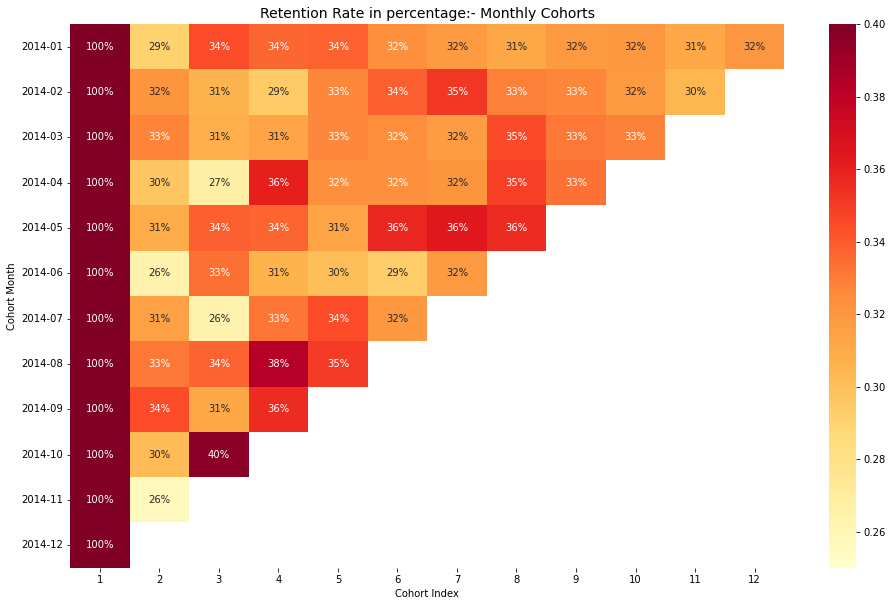

In [62]:
plt.figure(figsize = (16, 10))

sns.heatmap(retention, annot = True, fmt = '.0%', cmap='YlOrRd', vmin = 0.25 , vmax = 0.4)

plt.title('Retention Rate in percentage:- Monthly Cohorts', fontsize = 14)
plt.ylabel('Cohort Month')
plt.xlabel('Cohort Index')
plt.yticks( rotation='360')

Subsequent analyses can be carried out using the framework provided by the cohort_date and offset variables, along with another variable representing a transaction expenditure amount for each customer.

### Avg Transaction Cost Cohort

In [63]:
'''Creating a new cohort df for the average transaction cost.'''
cohort_data = transactions.groupby(['cohort_date', 'offset'])['tran_amount'].mean().reset_index()

In [64]:
'''Creating a pivot table for visualization.'''
avg_trans_amount = cohort_data.pivot(index = 'cohort_date', columns = 'offset', values = 'tran_amount')

In [65]:
'''Making cohort index more legible.'''
avg_trans_amount.index = avg_trans_amount.index.strftime('%Y-%m')

In [66]:
''' Rounding transaction values '''
avg_trans_amount = avg_trans_amount.round(1)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0, 0.5, '2014-01'),
  Text(0, 1.5, '2014-02'),
  Text(0, 2.5, '2014-03'),
  Text(0, 3.5, '2014-04'),
  Text(0, 4.5, '2014-05'),
  Text(0, 5.5, '2014-06'),
  Text(0, 6.5, '2014-07'),
  Text(0, 7.5, '2014-08'),
  Text(0, 8.5, '2014-09'),
  Text(0, 9.5, '2014-10'),
  Text(0, 10.5, '2014-11'),
  Text(0, 11.5, '2014-12')])

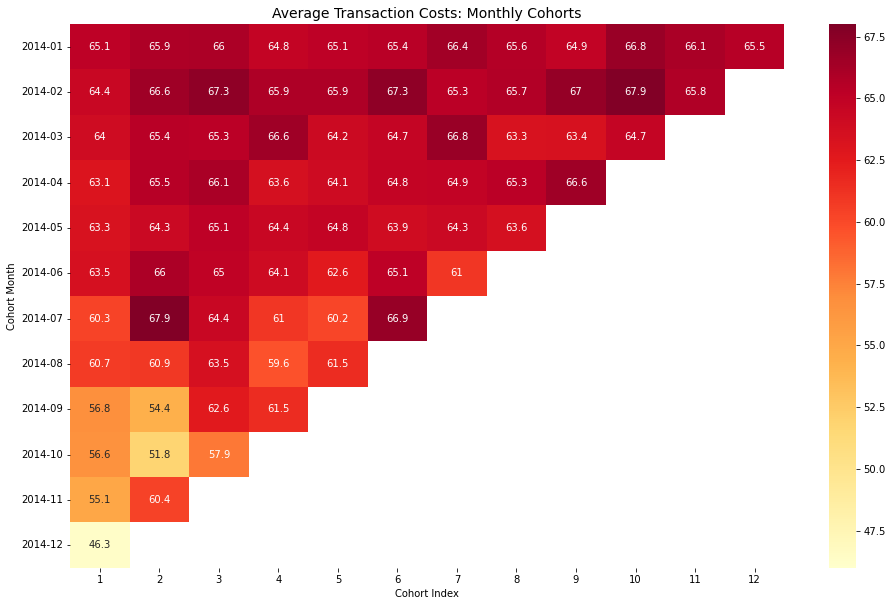

In [67]:
'''Initialize the figure'''
plt.figure(figsize=(16, 10))

'''Adding a title'''
plt.title('Average Transaction Costs: Monthly Cohorts', fontsize = 14)

'''Creating the heatmap'''
sns.heatmap(avg_trans_amount, annot = True, vmin = 46, vmax = 68, cmap = "YlOrRd", fmt = 'g')
plt.ylabel('Cohort Month')
plt.xlabel('Cohort Index')
plt.yticks(rotation='360')